In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [3]:
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

Using TensorFlow backend.


In [5]:
X = np.load('C:/Users/AKINTOLA/Downloads/archive/X.npy') # Images 
Y = np.load('C:/Users/AKINTOLA/Downloads/archive/Y.npy') # Images labels {1} for IDC and {0} signifies no IDF

In [6]:
def describe(a, b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describe(X,Y)

Total number of images: 5547
Number of IDC(-) Images: 2759
Number of IDC(+) Images: 2788
Percentage of positive images: 50.26%
Image shape (Width, Height, Channels): (50, 50, 3)


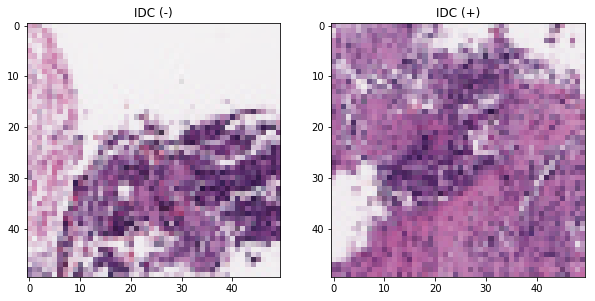

In [25]:
imgs0 = X[Y==0] # (0 = no IDC, 1 = IDC)
imgs1 = X[Y==1] 

def plotOne(a, b):
    """
    Plot one numpy array
    """
    fig, ax = plt.subplots(figsize = (10, 8))
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[100])
    
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[100])
    
plotOne(imgs0, imgs1)

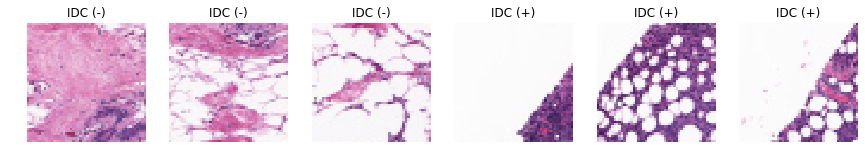

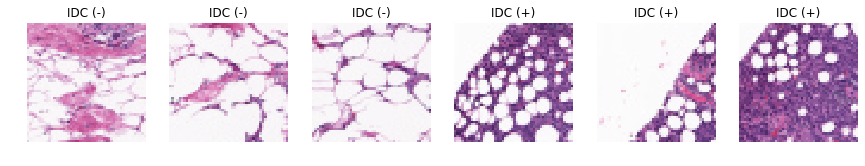

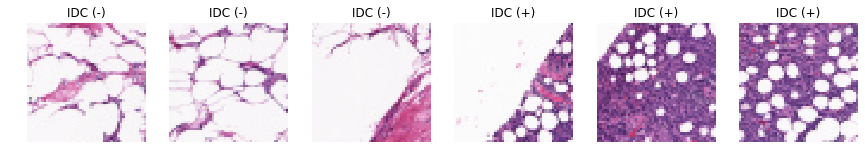

In [26]:
def plot_two(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[row+col])
            plt.axis('off')
            
plot_two(imgs0, imgs1) 

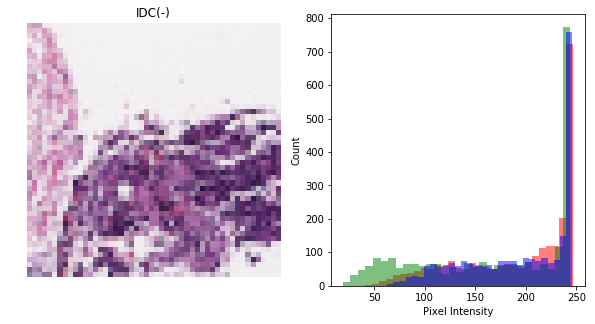

In [27]:
def plot_histogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
    
plot_histogram(X[100])

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:30000] 
Y_train = Y_train[0:30000]
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000]

# Normalize the data
X_train = X_train / 256.0
X_test = X_test / 256.0

print("Training Data Shape:", X_train.shape, X_train.shape)
print("Testing Data Shape:", X_test.shape, X_test.shape)

Training Data Shape: (4437, 50, 50, 3) (4437, 50, 50, 3)
Testing Data Shape: (1110, 50, 50, 3) (1110, 50, 50, 3)


In [29]:
# Find the unique numbers from the train labels
classes = np.unique(Y_train)
n_classes = len(classes)
print('Total number of outputs : ', n_classes)
print('Output classes : ', classes)

Total number of outputs :  2
Output classes :  [0 1]


Text(0.5, 1.0, 'Test ground Truth')

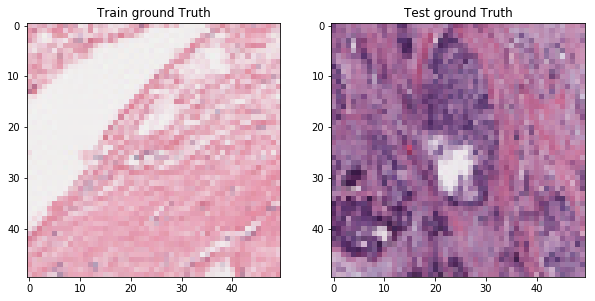

In [30]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[0,:], cmap='gray')
plt.title("Train ground Truth")

# Display the first image in testing data
plt.subplot(122)
plt.imshow(X_test[0, :], cmap='gray')
plt.title("Test ground Truth")

In [31]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

In [32]:
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

In [33]:
def run_keras_CNN(a,b,c,d):
    """
    https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 128
    num_classes = 2
    epochs = 12  
    img_rows, img_cols = X_train.shape[1],X_train.shape[2]
    input_shape = (img_rows, img_cols, 3)
    x_train = a
    y_train = b
    x_test = c
    y_test = d   
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.fit(x_train, y_train,
              batch_size=batch_size,
              verbose=1,
              epochs=epochs,
              validation_data=(x_test, y_test),callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(x_test, y_test, verbose=0)
    print('\nKeras CNN #1A - accuracy:', score[1],'\n')
    y_pred = model.predict(c) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(Y_test,axis = 1) 
run_keras_CNN(X_train, Y_train,  X_test, Y_test)


Train on 4437 samples, validate on 1110 samples
Epoch 1/12
4437/4437 [==============================] - 87s 20ms/step - loss: 0.7646 - accuracy: 0.5344 - val_loss: 0.6503 - val_accuracy: 0.5937
Epoch 2/12
4437/4437 [==============================] - 79s 18ms/step - loss: 0.7431 - accuracy: 0.6265 - val_loss: 0.6669 - val_accuracy: 0.5649
Epoch 3/12
4437/4437 [==============================] - 64s 14ms/step - loss: 0.6395 - accuracy: 0.6588 - val_loss: 0.7510 - val_accuracy: 0.4973
Epoch 4/12
4437/4437 [==============================] - 79s 18ms/step - loss: 0.6240 - accuracy: 0.6653 - val_loss: 0.5895 - val_accuracy: 0.6883
Epoch 5/12
4437/4437 [==============================] - 68s 15ms/step - loss: 0.6029 - accuracy: 0.6906 - val_loss: 0.5583 - val_accuracy: 0.7586
Epoch 6/12
4437/4437 [==============================] - 74s 17ms/step - loss: 0.5917 - accuracy: 0.7041 - val_loss: 0.5284 - val_accuracy: 0.7766
Epoch 7/12
4437/4437 [==============================] - 83s 19ms/step - los

In [47]:
def plot_keras_learning_curve():
    plt.figure(figsize=(15,10))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

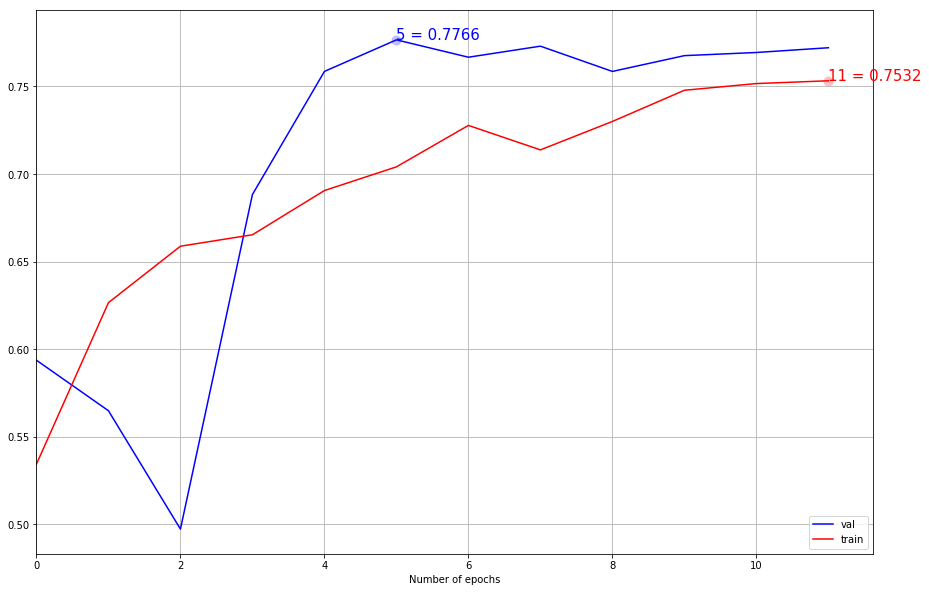

In [48]:
plot_keras_learning_curve()